#Урок 5. Сегментация изображений.
#Домашнее задание


1.   Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2.   Обучить модель на выбор из segmentation_models_pytorch


In [55]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [56]:
DATA_ROOT = 'set-lipstick-original/'

Посмотрим изображение и маску

(720, 1280, 3)


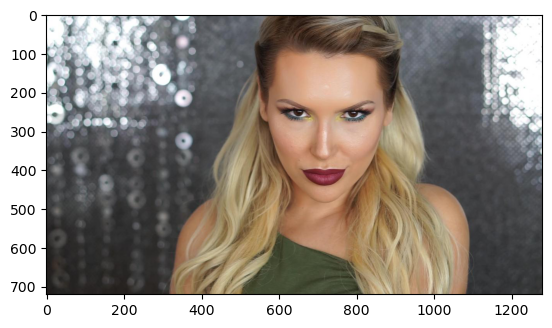

In [57]:
img = plt.imread(DATA_ROOT + '720p/image00000001.jpg')
print(img.shape)
plt.imshow(img);

Маска также имеет 3 канала, но основной цвет - зеленый, на втором канале:

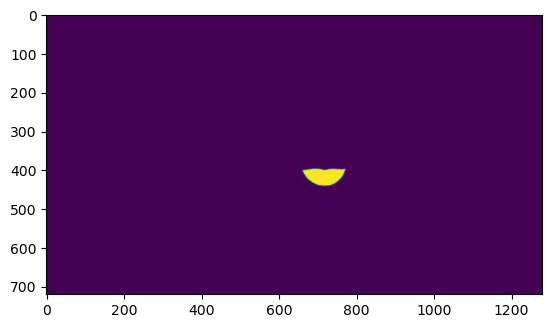

In [58]:
img = plt.imread(DATA_ROOT + 'mask/mask00000001.png')
plt.imshow(img[..., 1]);

Скачаем датасет

In [59]:
df_images = pd.read_csv(DATA_ROOT + 'list.csv')
df_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [60]:
df_images = df_images[['filename', 'mask']]
df_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


Проверим, для всех ли изображений есть маски:

In [61]:
list_images = sorted([i for i in Path(DATA_ROOT + '720p').iterdir()])
list_masks = sorted([i for i in Path(DATA_ROOT + 'mask').iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

Как видно, не для всех. Уберем изображения, для которых нет масок:

In [62]:
df_images = df_images.loc[df_images['mask'].isin([i.name for i in list_masks])]
df_images.reset_index(drop=True, inplace=True)
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


Подготовим класс для кастомного датасета. Для маски возьмем значения, больше 10:

In [63]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(DATA_ROOT + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        mask = cv2.cvtColor(cv2.imread(DATA_ROOT + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

Инициализируем устройство, на котором будем обучать модель:

In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Инициализируем Unet с предобученным энкодером resnet34:

In [66]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [67]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Создадим датасет, для препроцессинга используем препроцессинг resnet34, обученный на imagenet:

C:\Users\User\AppData\Local\Temp\ipykernel_11268\334641505.py:42: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


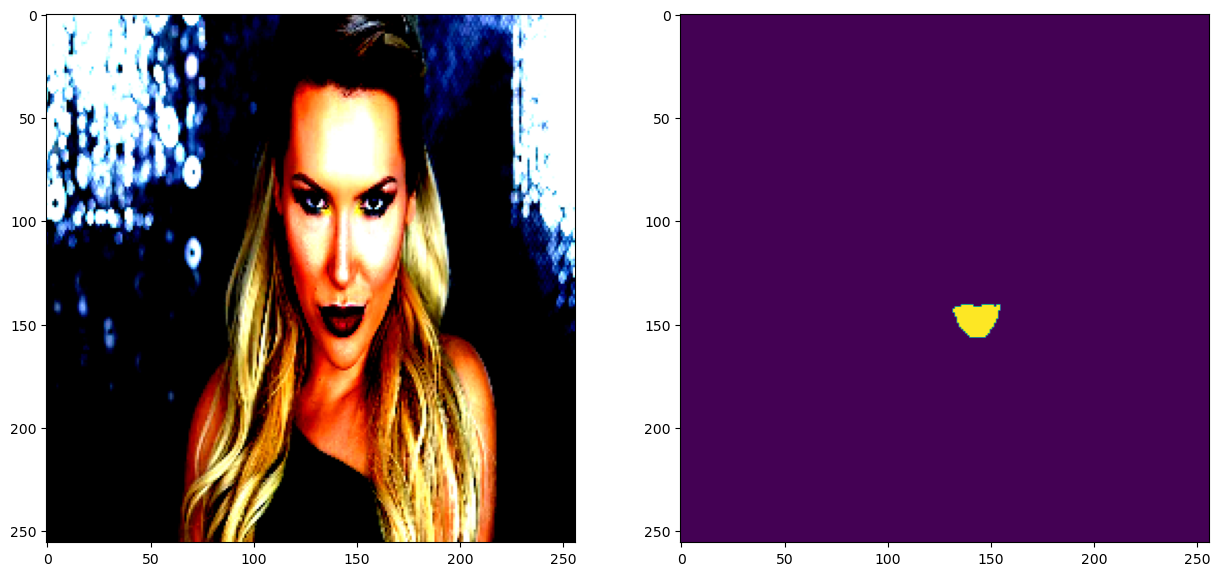

In [68]:
dataset = LipsDataset(df_images, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

Разделим выборку на обучающую и тестовую:

In [70]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df_images, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

Инициализируем даталоадер:

In [71]:
train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False
)

Проверим диапазон значений в тензорах:

C:\Users\User\AppData\Local\Temp\ipykernel_11268\334641505.py:42: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


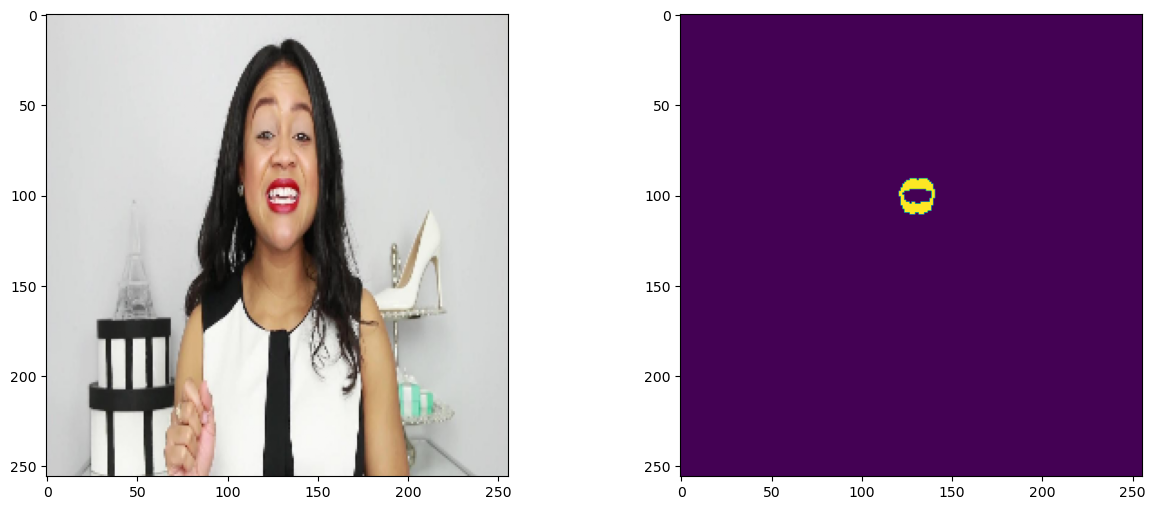

In [72]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [73]:
print(segmodel)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Заморозим веса энкодера:

In [74]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [75]:
summary(segmodel.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

Как видно, из 24 млн параметров, обучить надо всего 3 млн

Инициализируем функцию потерь, метрику и оптимизатор с обучаемыми параметрами:

In [76]:
criterion = smp.losses.DiceLoss(mode='binary')
tp, fp, fn, tn = smp.metrics.get_stats(outputs, test_data, mode='multilabel', threshold=0.5)
metrics = [smp.metrics.iou_score(tp, fp, fn, tn),]

params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

NameError: name 'outputs' is not defined

In [52]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)




NameError: name 'metrics' is not defined

Обучим модель. Такой метрики удалось добиться всего за 2 эпохи.

In [30]:
# train model

# max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 1071/1071 [05:56<00:00,  3.01it/s, dice_loss - 0.03158, iou_score - 0.9403]
Model saved!


In [31]:
data_iter = iter(train_data_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

Визуализируем работу сети. На некоторых снимках кажется, что сеть просегментировала изображения лучше разметчика.

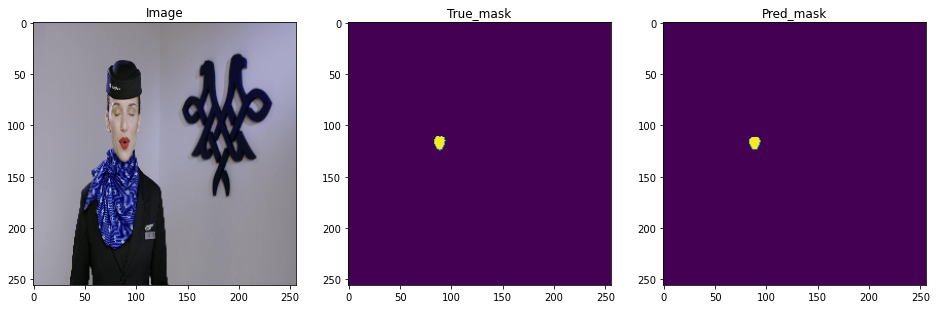

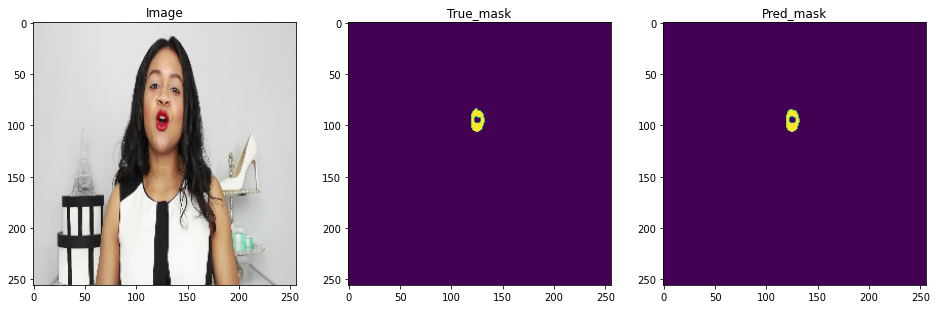

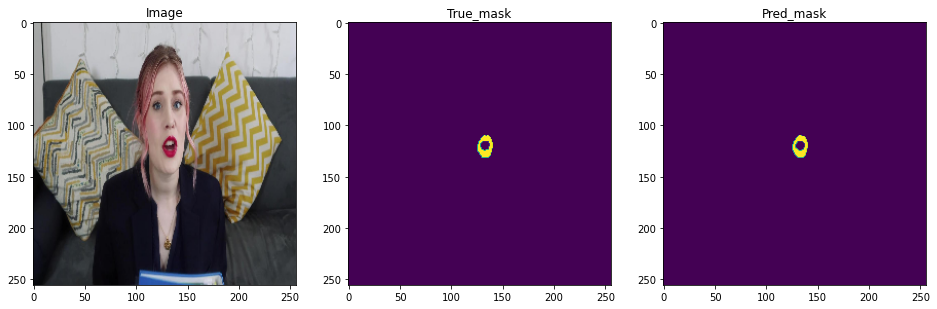

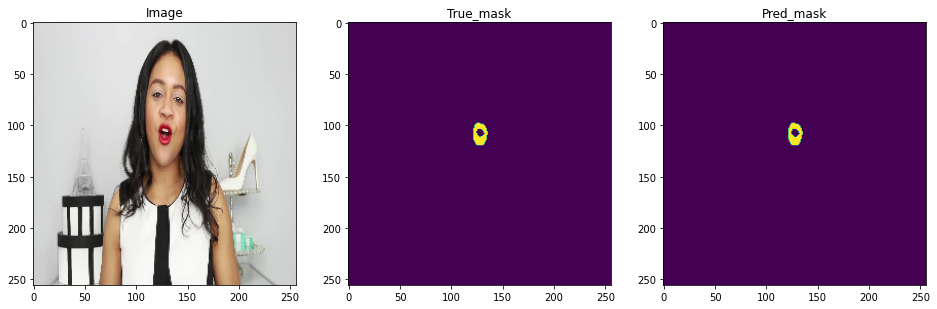

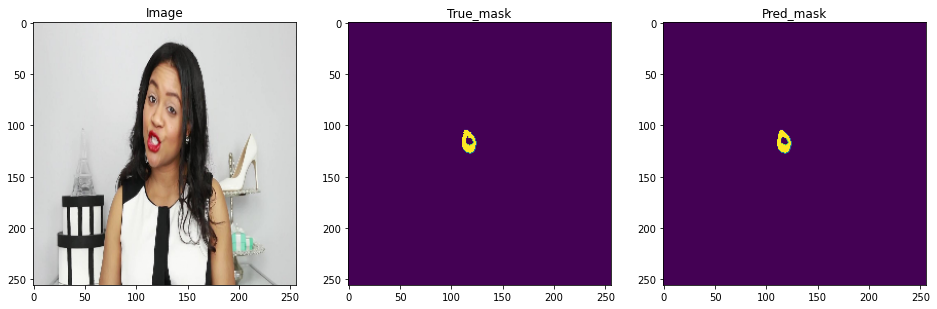

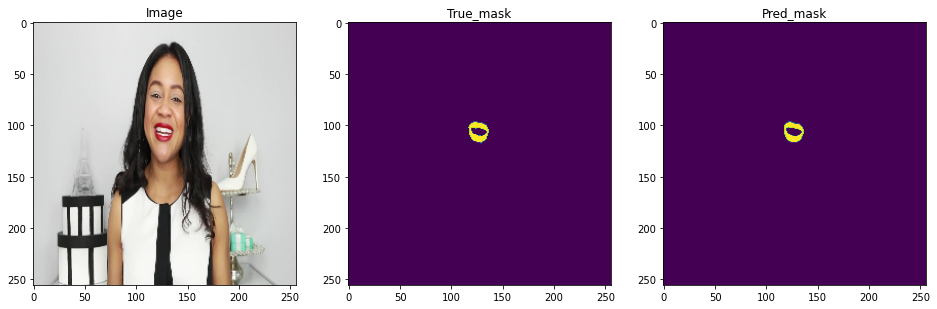

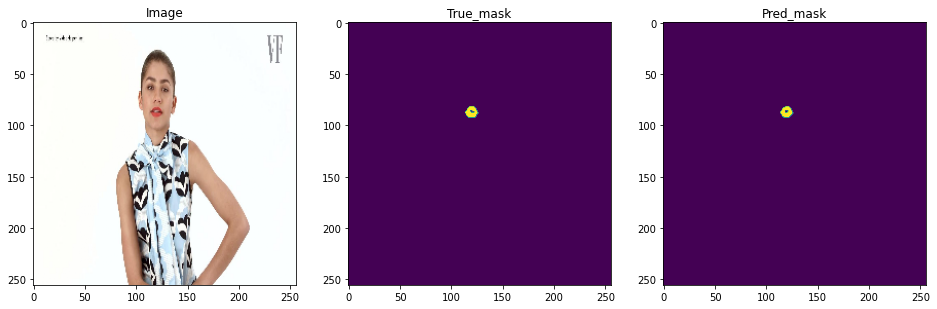

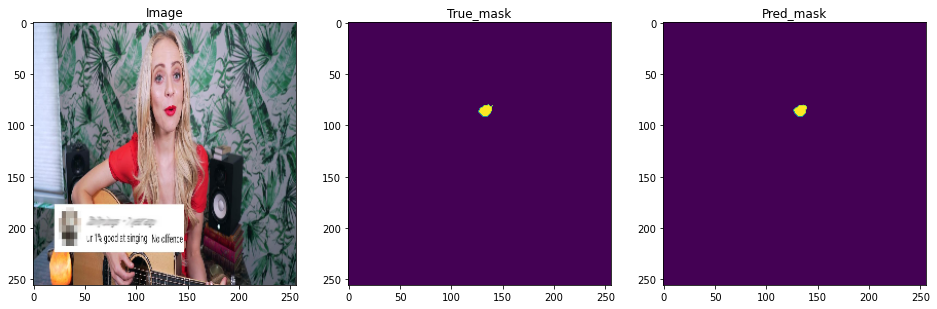

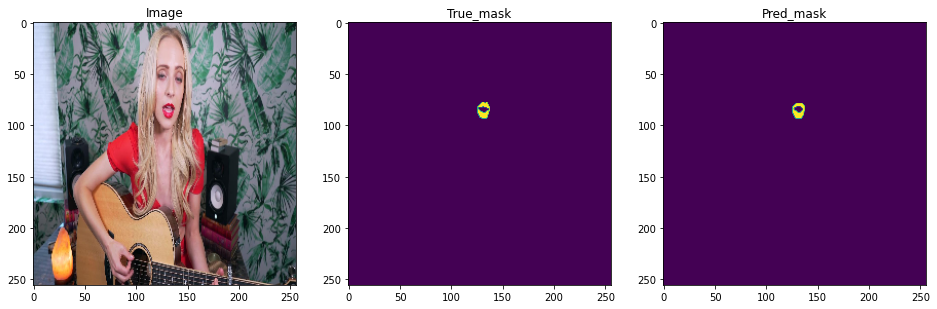

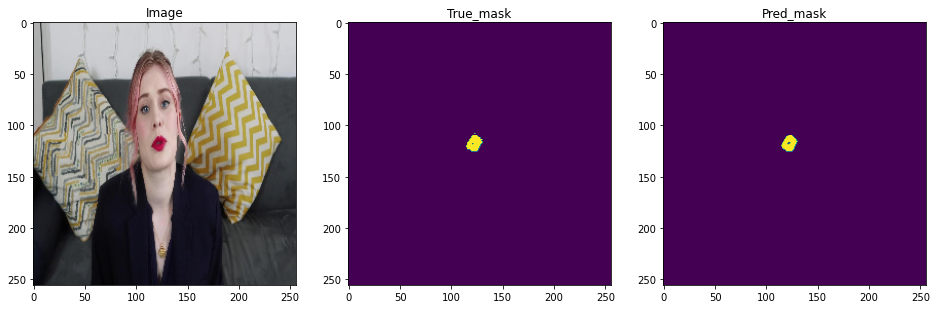

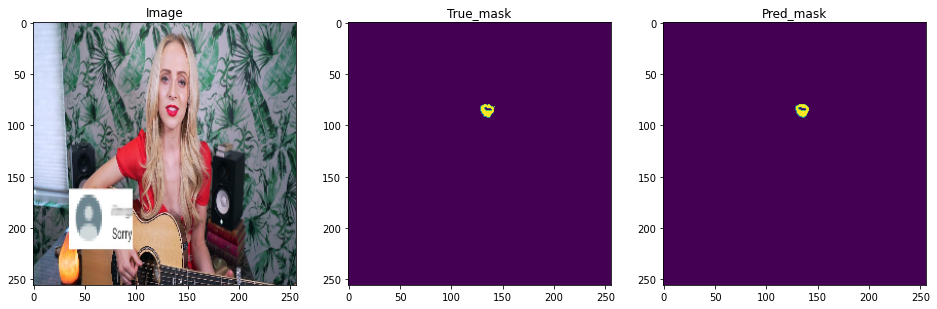

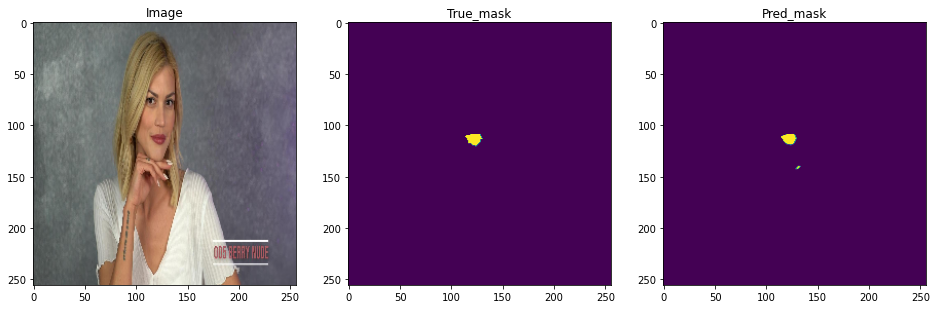

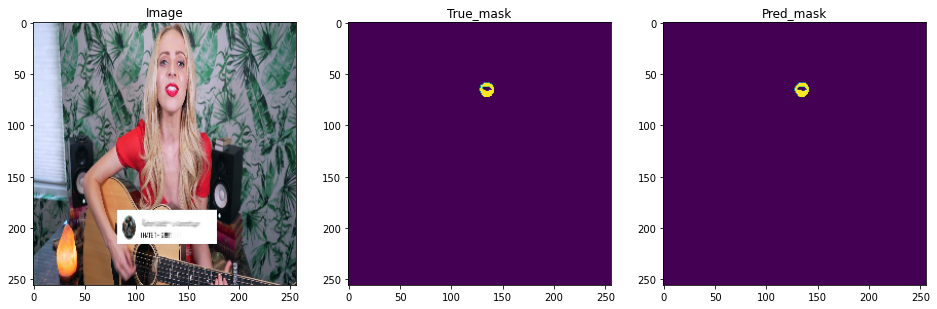

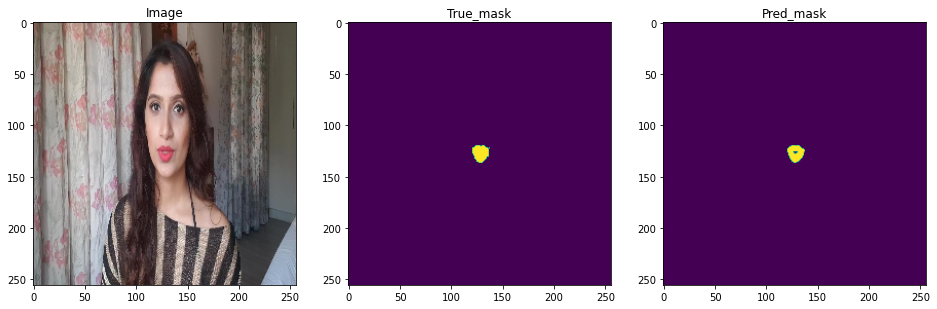

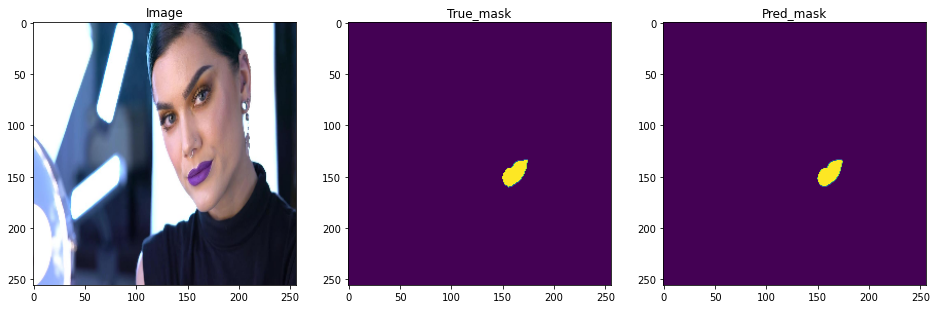

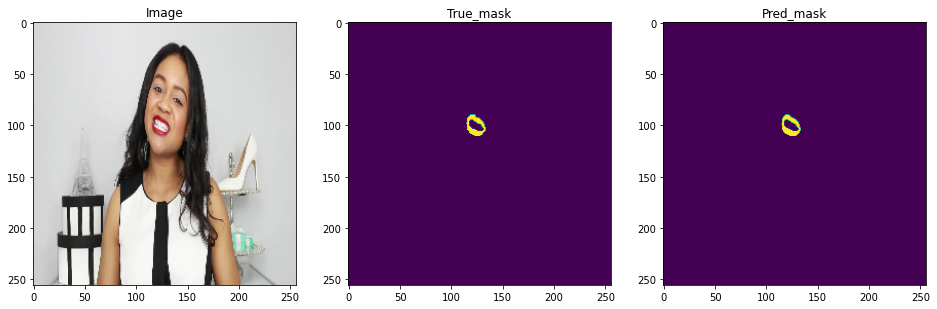

In [32]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')